# Problem 4

### Starter Code from Kernel_starter.ipynb

In [1]:
import pickle
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
from numpy.linalg import norm

In [2]:
def check_gradient(model, X, y, dimensionality, verbose=True):
    # This checks that the gradient implementation is correct
    w = np.random.rand(dimensionality)
    f, g = model.funObj(w, X, y)

    # Check the gradient
    estimated_gradient = approx_fprime(w,
                                       lambda w: model.funObj(w,X,y)[0],
                                       epsilon=1e-6)

    implemented_gradient = model.funObj(w, X, y)[1]

    if np.max(np.abs(estimated_gradient - implemented_gradient) > 1e-3):
        raise Exception('User and numerical derivatives differ:\n%s\n%s' %
             (estimated_gradient[:5], implemented_gradient[:5]))
    else:
        if verbose:
            print('User and numerical derivatives agree.')

In [3]:
def plotClassifier(model, X, y):
    """plots the decision boundary of the model and the scatterpoints
       of the target values 'y'.

    Assumptions
    -----------
    y : it should contain two classes: '1' and '2'

    Parameters
    ----------
    model : the trained model which has the predict function

    X : the N by D feature array

    y : the N element vector corresponding to the target values

    """
    x1 = X[:, 0]
    x2 = X[:, 1]

    x1_min, x1_max = int(x1.min()) - 1, int(x1.max()) + 1
    x2_min, x2_max = int(x2.min()) - 1, int(x2.max()) + 1

    x1_line =  np.linspace(x1_min, x1_max, 200)
    x2_line =  np.linspace(x2_min, x2_max, 200)

    x1_mesh, x2_mesh = np.meshgrid(x1_line, x2_line)

    mesh_data = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]

    y_pred = model.predict(mesh_data)
    y_pred = np.reshape(y_pred, x1_mesh.shape)

    plt.figure()
    plt.xlim([x1_mesh.min(), x1_mesh.max()])
    plt.ylim([x2_mesh.min(), x2_mesh.max()])

    plt.contourf(x1_mesh, x2_mesh, -y_pred.astype(int), # unsigned int causes problems with negative sign... o_O
                cmap=plt.cm.RdBu, alpha=0.6)


    y_vals = np.unique(y)
    plt.scatter(x1[y==y_vals[0]], x2[y==y_vals[0]], color="b", label="class %+d" % y_vals[0])
    plt.scatter(x1[y==y_vals[1]], x2[y==y_vals[1]], color="r", label="class %+d" % y_vals[1])
    plt.legend()

In [4]:
def findMin(funObj, w, maxEvals, *args, verbose=0):
    """
    Uses gradient descent to optimize the objective function

    This uses quadratic interpolation in its line search to
    determine the step size alpha
    """
    # Parameters of the Optimization
    optTol = 1e-2
    gamma = 1e-4

    # Evaluate the initial function value and gradient
    f, g = funObj(w,*args)
    funEvals = 1

    alpha = 1.
    while True:
        # Line-search using quadratic interpolation to 
        # find an acceptable value of alpha
        gg = g.T.dot(g)

        while True:
            w_new = w - alpha * g
            f_new, g_new = funObj(w_new, *args)

            funEvals += 1
            if f_new <= f - gamma * alpha*gg:
                break

            if verbose > 1:
                print("f_new: %.3f - f: %.3f - Backtracking..." % (f_new, f))

            # Update step size alpha
            alpha = (alpha**2) * gg/(2.*(f_new - f + alpha*gg))

        # Print progress
        if verbose > 0:
            print("%d - loss: %.3f" % (funEvals, f_new))

        # Update step-size for next iteration
        y = g_new - g
        alpha = -alpha*np.dot(y.T,g) / np.dot(y.T,y)

        # Safety guards
        if np.isnan(alpha) or alpha < 1e-10 or alpha > 1e10:
            alpha = 1.

        if verbose > 1:
            print("alpha: %.3f" % (alpha))

        # Update parameters/function/gradient
        w = w_new
        f = f_new
        g = g_new

        # Test termination conditions
        optCond = norm(g, float('inf'))

        if optCond < optTol:
            if verbose:
                print("Problem solved up to optimality tolerance %.3f" % optTol)
            break

        if funEvals >= maxEvals:
            if verbose:
                print("Reached maximum number of function evaluations %d" % maxEvals)
            break

    return w, f

In [5]:
def log_1_plus_exp_safe(x):
    out = np.log(1+np.exp(x))
    out[x > 100] = x[x>100]
    out[x < -100] = np.exp(x[x < -100])
    return out

In [6]:
def kernel_linear(X1, X2):
    return X1@X2.T

In [7]:
class kernelLogRegL2():
    def __init__(self, lammy=1.0, verbose=0, maxEvals=100, kernel_fun=kernel_linear, **kernel_args):
        self.verbose = verbose
        self.lammy = lammy
        self.maxEvals = maxEvals
        self.kernel_fun = kernel_fun
        self.kernel_args = kernel_args

    def funObj(self, u, K, y):
        yKu = y * (K@u)

        # Calculate the function value
        # f = np.sum(np.log(1. + np.exp(-yKu)))
        f = np.sum(log_1_plus_exp_safe(-yKu))

        # Add L2 regularization
        f += 0.5 * self.lammy * u.T@K@u

        # Calculate the gradient value
        res = - y / (1. + np.exp(yKu))
        g = (K.T@res) + self.lammy * K@u

        return f, g


    def fit(self, X, y):
        n, d = X.shape
        self.X = X

        K = self.kernel_fun(X,X, **self.kernel_args)

        check_gradient(self, K, y, n, verbose=self.verbose)
        self.u, f = findMin(self.funObj, np.zeros(n), self.maxEvals, K, y, verbose=self.verbose)

    def predict(self, Xtest):
        Ktest = self.kernel_fun(Xtest, self.X, **self.kernel_args)
        return np.sign(Ktest@self.u)

### Start of my own code

In [8]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

#import the nonlineardata.csv file
df = pd.read_csv("nonlineardata.csv",header=None)

#access the x and y data sets
data = df.to_numpy()
X = data[:,0:2]
Y = data[:,2]

#split the data into 80% training and 20% testing with random state to 2022
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=2022)



## 4.1 SVM with linear Kernel, C = 100

Test Accuracy: 0.7625
Train Accuracy: 0.8125


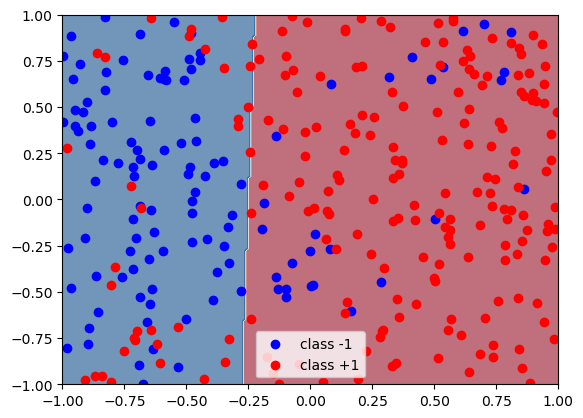

In [9]:
clf = SVC(C=100,kernel="linear")
clf.fit(X_train,Y_train)

train_accuracy = clf.score(X_train,Y_train)
test_accuracy = clf.score(X_test,Y_test)

out_str = "Test Accuracy: {}\nTrain Accuracy: {}".format(test_accuracy,train_accuracy)
print(out_str)

plotClassifier(clf,X_train,Y_train)

### 4.2 Polynomial Kernel, r = 1, degree = 2, C = 100

Test Accuracy: 0.775
Train Accuracy: 0.828125


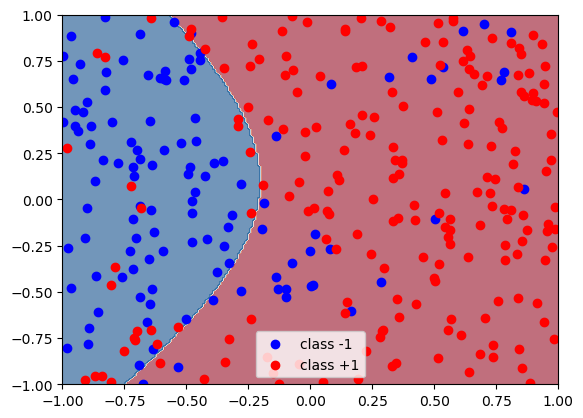

In [10]:
clf = SVC(C=100,kernel="poly",degree = 2, coef0 = 1)
clf.fit(X_train,Y_train)

train_accuracy = clf.score(X_train,Y_train)
test_accuracy = clf.score(X_test,Y_test)

out_str = "Test Accuracy: {}\nTrain Accuracy: {}".format(test_accuracy,train_accuracy)
print(out_str)

plotClassifier(clf,X_train,Y_train)

### 4.3 RBF Kernel with sigma = 0.5, C = 100

Test Accuracy: 0.85
Train Accuracy: 0.9


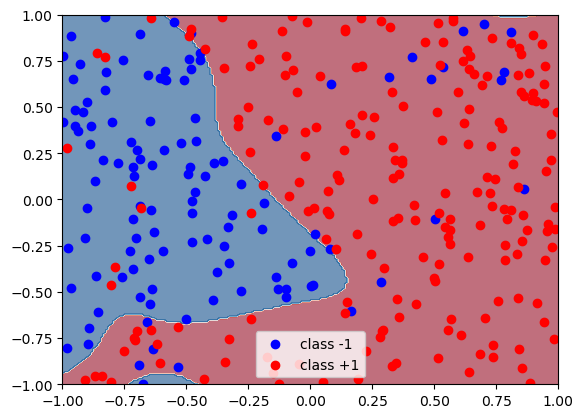

In [11]:
clf = SVC(C=100,kernel="rbf", gamma=1/pow(0.5,2))
clf.fit(X_train,Y_train)

train_accuracy = clf.score(X_train,Y_train)
test_accuracy = clf.score(X_test,Y_test)

out_str = "Test Accuracy: {}\nTrain Accuracy: {}".format(test_accuracy,train_accuracy)
print(out_str)

plotClassifier(clf,X_train,Y_train)

### 4.4 RBF Kernel Performance over several values of gamma

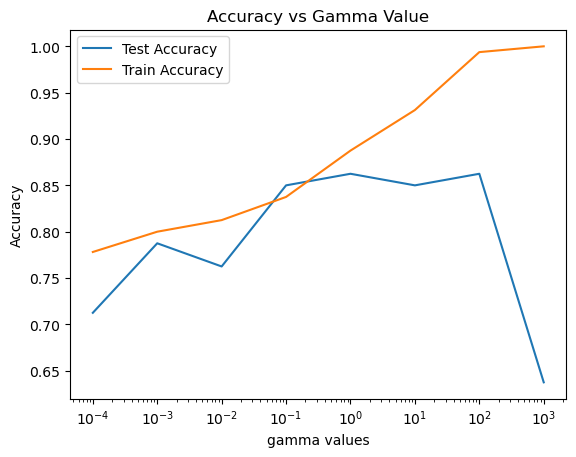

In [12]:
gamma_vals = np.array([1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
test_accuracies = np.zeros(np.shape(gamma_vals))
train_accuracies = np.zeros(np.shape(gamma_vals))

for i in range(np.size(gamma_vals)):
    clf = SVC(C=100,kernel="rbf", gamma=gamma_vals[i])
    clf.fit(X_train,Y_train)

    train_accuracies[i] = clf.score(X_train,Y_train)
    test_accuracies[i] = clf.score(X_test,Y_test)
    
fig,ax = plt.subplots()
ax.plot(gamma_vals,test_accuracies,label = "Test Accuracy")
ax.plot(gamma_vals,train_accuracies,label = "Train Accuracy")
ax.set_xlabel("gamma values")
ax.set_xscale("log")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Gamma Value")
ax.legend()

As gamma increases, the training error goes to 100 while the testing error decreases. This indicatest hat the model is overfitting at high values of gamma.

The reason that the model overfits for high values of gamma is due to the fact that the kernel is defined with exp(-gamma ||xi - xl||^(2)). Given this, for large values of gamma, the kernel term basically goes to zero leaving only the regularization term. Given this, the model then tries to exactly fit the training data which results in the model overfitting.

For small values of gamma, there is a high variance. This means that the model is more generalized and not overfit at the expense of not classifying all of the points in the training set perfectly.

### 4.5 L2 regularized Logistic Regression, Linear Kernel, lambda = 0.01

Test Accuracy: 0.7625
Train Accuracy: 0.7625


/tmp/ipykernel_4914/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/tmp/ipykernel_4914/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


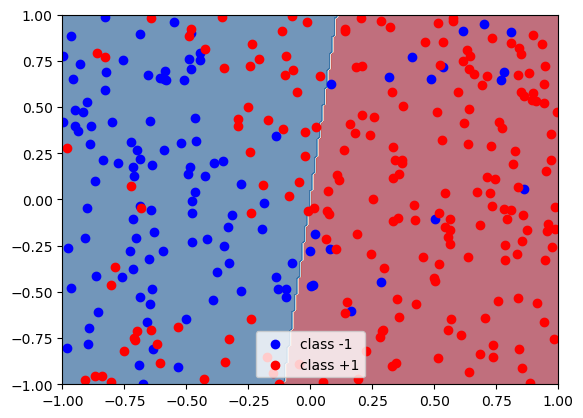

In [13]:
clf = kernelLogRegL2(lammy=0.01)
clf.fit(X_train,Y_train)

def get_accuracy(model,X,Y):
    f_x = model.predict(X)
    correct = f_x[f_x == Y]
    return float(np.size(correct))/float(np.size(Y))

train_accuracy = get_accuracy(clf,X_train,Y_train)
test_accuracy = get_accuracy(clf,X_test,Y_test)

out_str = "Test Accuracy: {}\nTrain Accuracy: {}".format(test_accuracy,train_accuracy)
print(out_str)

plotClassifier(clf,X_train,Y_train)

### 4.6: L2 Regularized Logistic Regression with polynomial kernel, lambda = 0.01


In [17]:
def kernel_poly(X1, X2, p=2):
    return np.power(np.add(1,np.matmul(X1,X2.transpose())),p)


/tmp/ipykernel_4914/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/tmp/ipykernel_4914/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


Test Accuracy: 0.8625
Train Accuracy: 0.834375


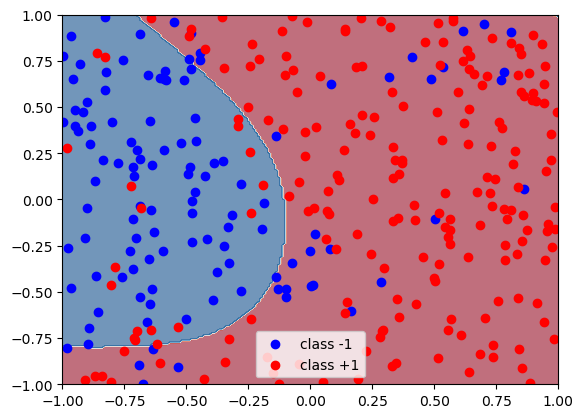

In [20]:
clf = kernelLogRegL2(lammy=0.01,kernel_fun=kernel_poly,p=3)
clf.fit(X_train,Y_train)

def get_accuracy(model,X,Y):
    f_x = model.predict(X)
    correct = f_x[f_x == Y]
    return float(np.size(correct))/float(np.size(Y))

train_accuracy = get_accuracy(clf,X_train,Y_train)
test_accuracy = get_accuracy(clf,X_test,Y_test)

out_str = "Test Accuracy: {}\nTrain Accuracy: {}".format(test_accuracy,train_accuracy)
print(out_str)

plotClassifier(clf,X_train,Y_train)

### 4.7 L2 Regularized Logistic Regression with RBF Kernel, sigma = 0.5, Lambda = 0.01

In [37]:
def kernel_RBF(X1, X2, gamma = 1):
    #Your code here
    n = np.shape(X1)[0]
    p = np.shape(X2)[0]
    K = np.zeros((n,p))
    
    #while inefficient, use a for loop to compute k
    for r in range(n):
        for c in range(p):
            K[r,c] = np.exp(-1 * gamma * pow(np.linalg.norm(X1[r] - X2[c]),2))
    
    return K

/tmp/ipykernel_4914/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/tmp/ipykernel_4914/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


Test Accuracy: 0.85
Train Accuracy: 0.8875


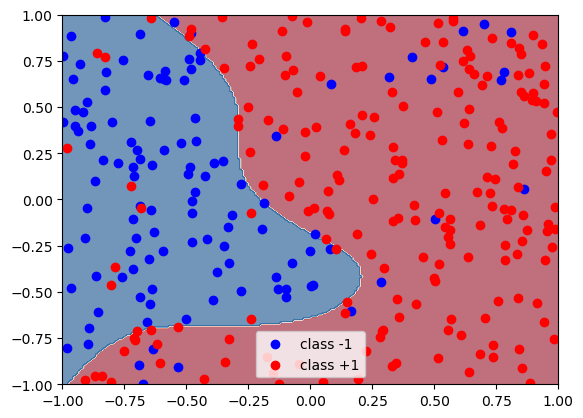

In [38]:
clf = kernelLogRegL2(lammy=0.01,kernel_fun=kernel_RBF,gamma = 1/pow(0.5,2))
clf.fit(X_train,Y_train)

def get_accuracy(model,X,Y):
    f_x = model.predict(X)
    correct = f_x[f_x == Y]
    return float(np.size(correct))/float(np.size(Y))

train_accuracy = get_accuracy(clf,X_train,Y_train)
test_accuracy = get_accuracy(clf,X_test,Y_test)

out_str = "Test Accuracy: {}\nTrain Accuracy: {}".format(test_accuracy,train_accuracy)
print(out_str)

plotClassifier(clf,X_train,Y_train)

### 4.8 RBF Kernel with various values for gamma

/tmp/ipykernel_4914/470417373.py:2: RuntimeWarning: overflow encountered in exp
  out = np.log(1+np.exp(x))
/tmp/ipykernel_4914/2422820963.py:20: RuntimeWarning: overflow encountered in exp
  res = - y / (1. + np.exp(yKu))


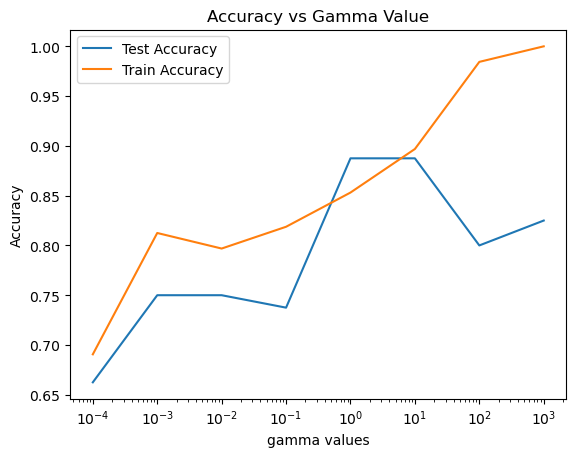

In [41]:
gamma_vals = np.array([1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3])
test_accuracies = np.zeros(np.shape(gamma_vals))
train_accuracies = np.zeros(np.shape(gamma_vals))

for i in range(np.size(gamma_vals)):
    clf = kernelLogRegL2(lammy=0.01,kernel_fun=kernel_RBF,gamma = gamma_vals[i])
    clf.fit(X_train,Y_train)

    train_accuracies[i] = get_accuracy(clf,X_train,Y_train)
    test_accuracies[i] = get_accuracy(clf,X_test,Y_test)
    
fig,ax = plt.subplots()
ax.plot(gamma_vals,test_accuracies,label = "Test Accuracy")
ax.plot(gamma_vals,train_accuracies,label = "Train Accuracy")
ax.set_xlabel("gamma values")
ax.set_xscale("log")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Gamma Value")
ax.legend()

# Problem 5 Sparse Logistic Regression
### 5.1 ROC curves for PECTF dataset

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

#import the nonlineardata.csv file
df = pd.read_csv("spectf.csv",header=None)

#access the x and y data sets
data = df.to_numpy()
X = data[:,1:]
Y = data[:,0]

#split the data into 80% training and 20% testing with random state to 2022
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25,random_state=2022)

Text(0.5, 1.0, 'ROC curve for each feature')

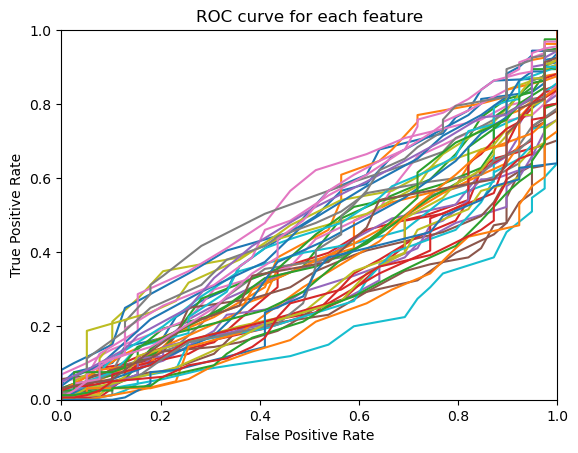

In [57]:
num_features = np.shape(X)[1]
feature_AUCs = np.zeros(num_features)

#initialize the plot
fig,ax = plt.subplots()
for i in range(num_features):
    fpr,tpr,thresholds = roc_curve(Y_train,X_train[:,i])
    feature_AUCs[i] = auc(fpr,tpr)
    ax.plot(fpr,tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title("ROC curve for each feature")


### 5.2 Creating 300 different subsets of features

To start, I recognize that the best features will have an AUC furthest from 0.5. For example, on the above plot, there are some features with an AUC well below 0.5, but this just means that the negation of the prediction was right more often than not (which is still useful). Given this, I prioritize the features with AUC furthest from 0.5

Next, I decided to co